In [1]:
%matplotlib inline
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.finfo(np.float32).eps*10, np.sqrt(np.finfo(np.float32).eps)

(1.1920928955078125e-06, 0.00034526698)

In [3]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib/keras_ex')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from gkernel.sklearn import RBFClassifier, make_model_gkernel3, make_model_gkernel1

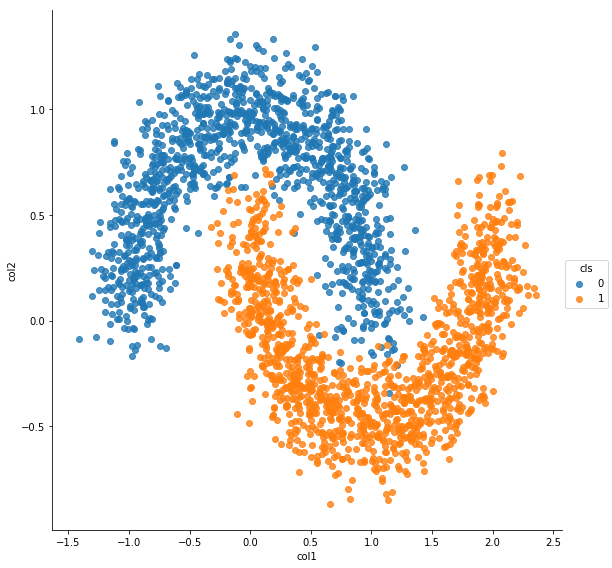

In [4]:
from sklearn.datasets import make_moons

n_samples = 2500
X1, y1 = make_moons(n_samples=n_samples, noise=.15, random_state=0)
df = pd.DataFrame(X1)
df.columns = ["col1", "col2"]
df['cls'] = y1

sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

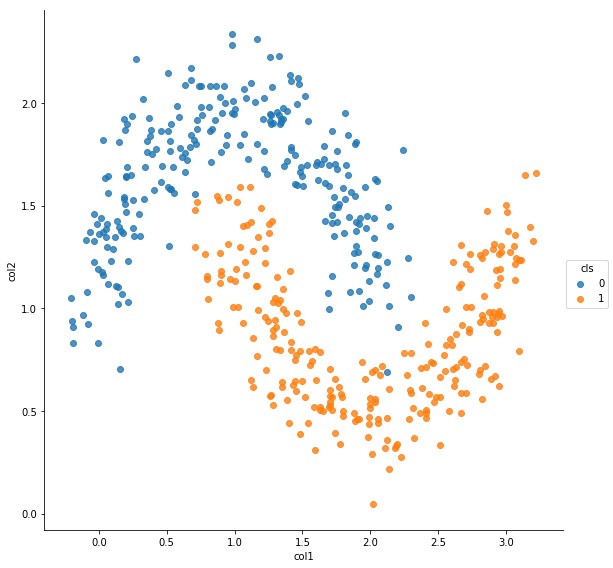

In [5]:
n_samples = 500
X2, y2 = make_moons(n_samples=n_samples, noise=.15, random_state=0)
X2[:,0] += 1
X2[:,1] += 1
df = pd.DataFrame(X2)
df.columns = ["col1", "col2"]
df['cls'] = y2

sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

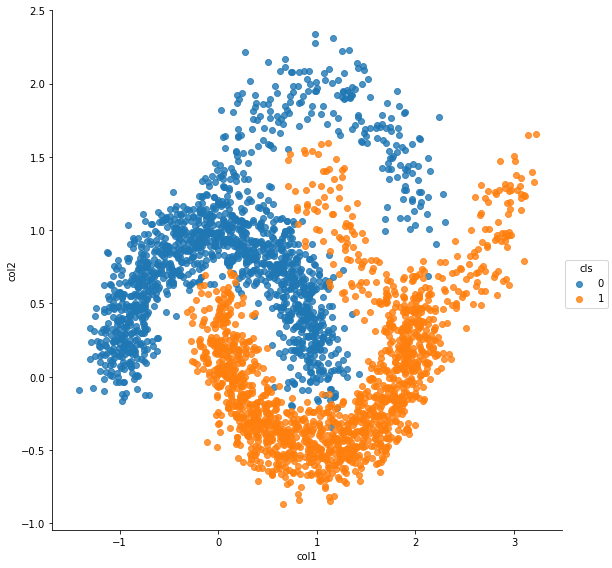

In [6]:
X = np.r_[X1,X2]
y = np.concatenate([y1, y2])

df = pd.DataFrame(X)
df.columns = ["col1", "col2"]
df['cls'] = y

sns.lmplot("col1", "col2", hue="cls", data=df, fit_reg=False, size=8)

In [7]:
X.shape, X.min(), X.max()

((3000, 2), -1.4162335410213718, 3.2229096450864403)

In [8]:
y.shape

(3000,)

In [9]:
N = y.shape[0]
y2 = keras.utils.to_categorical(y, num_classes=2)
y2.shape
index = np.arange(N)
xtrain = X[index[index % 2 != 0],:]
ytrain = y2[index[index % 2 != 0]]
xtest = X[index[index % 2 == 0],:]
yans = y2[index[index % 2 == 0]]

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

### vector input

In [13]:
np.argmax(ytrain, axis=1)[:5]

array([1, 0, 1, 0, 0])

In [14]:
clf = RBFClassifier(
    num_lm=200,
    lm_select_from_x=True,
    random_state=None,
    lr=0.02, gamma='scale',
    epochs=500, batch_size=32, verbose=0
)

In [15]:
%%time
hst = clf.fit(xtrain, np.argmax(ytrain, axis=1), epochs=500, batch_size=32, verbose=0)

W1001 00:23:58.741031 140637739312960 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1001 00:23:58.744353 140637739312960 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1001 00:23:58.780273 140637739312960 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 00:23:58.790339 140637739312960 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: T

CPU times: user 12.9 s, sys: 283 ms, total: 13.2 s
Wall time: 23.2 s


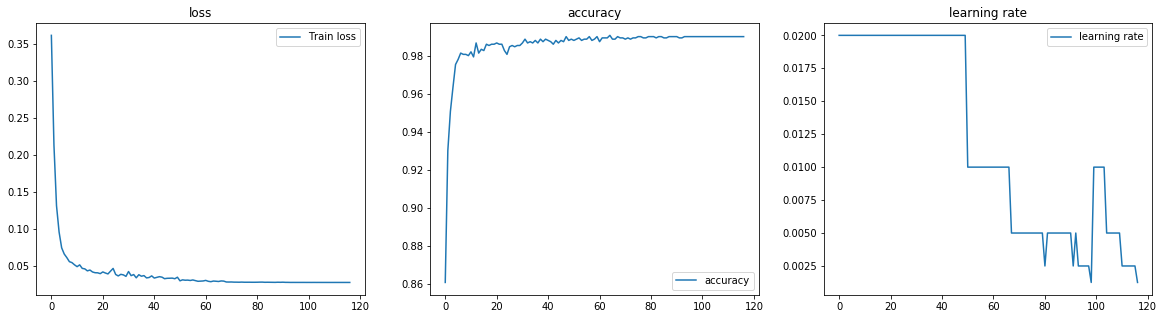

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [17]:
clf.sk_params

{'batch_size': 32,
 'callbacks': None,
 'epochs': 500,
 'gamma': 'scale',
 'lm': None,
 'lm_select_from_x': True,
 'loss': None,
 'lr': 0.02,
 'nn': None,
 'num_cls': 2,
 'num_lm': 200,
 'random_state': None,
 'verbose': 0}

In [18]:
clf.current_gamma()

5.4130435

In [19]:
clf.predict(xtrain)[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [20]:
clf.predict_proba(xtrain)[:5]

array([[5.4863045e-07, 9.9999940e-01],
       [9.9992263e-01, 7.7393983e-05],
       [2.3468224e-02, 9.7653174e-01],
       [9.9999380e-01, 6.1831993e-06],
       [9.9823904e-01, 1.7609785e-03]], dtype=float32)

In [21]:
clf.score(xtrain, np.argmax(ytrain, axis=1))

0.99

In [22]:
clf.score(xtest, np.argmax(yans,axis=1))

0.988

In [23]:
print('F1_SCORE :', f1_score(np.argmax(ytrain,axis=1), clf.predict(xtrain), average='macro'))
print(classification_report(np.argmax(ytrain,axis=1), clf.predict(xtrain)))
print(confusion_matrix(np.argmax(ytrain,axis=1), clf.predict(xtrain)))

F1_SCORE : 0.9899823288280527
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       720
           1       0.99      0.99      0.99       780

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

[[711   9]
 [  6 774]]


In [24]:
print('F1_SCORE :', f1_score(np.argmax(yans,axis=1), clf.predict(xtest), average='macro'))
print(classification_report(np.argmax(yans,axis=1), clf.predict(xtest)))
print(confusion_matrix(np.argmax(yans,axis=1), clf.predict(xtest)))

F1_SCORE : 0.9879832513227325
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       780
           1       0.98      0.99      0.99       720

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

[[769  11]
 [  7 713]]


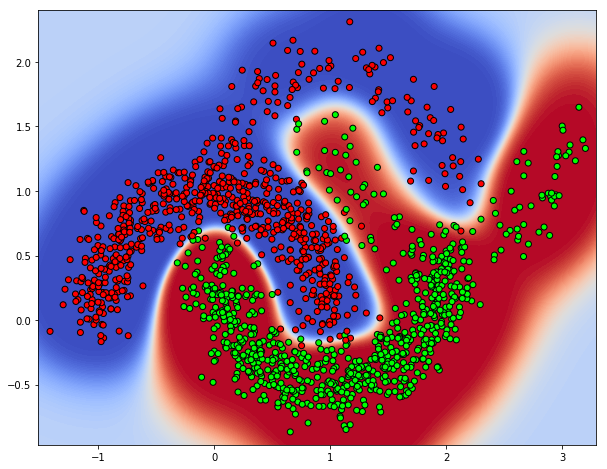

In [25]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

## BENCHMARK LogisticRegression

In [26]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [27]:
param_name = "C"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [28]:
%%time

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1.0 ...........................................................
[CV] ............................................ C=1.0, total=   0.0s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=1000.0 ........................................................
[CV] ......................................... C=1000.0, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.6s finished


In [29]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 3.36178284e-01, 3.36178284e-01],
       [1.00000000e-02, 8.32691583e-01, 8.44029982e-01],
       [1.00000000e-01, 8.55494121e-01, 8.70265545e-01],
       [1.00000000e+00, 8.57895043e-01, 8.74090601e-01],
       [1.00000000e+01, 8.57556420e-01, 8.74090601e-01],
       [1.00000000e+02, 8.57556420e-01, 8.74090601e-01],
       [1.00000000e+03, 8.57556420e-01, 8.74090601e-01]])

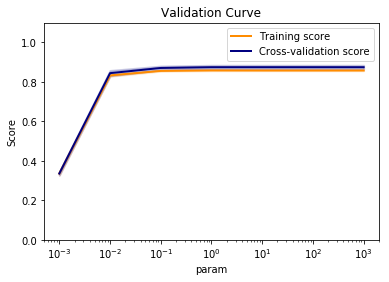

In [30]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [31]:
'''test data'''
est = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1.0)
est.fit(xtrain, np.argmax(ytrain, axis=1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
pred = est.predict(xtrain)

In [33]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.8637820512820513
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       720
           1       0.87      0.87      0.87       780

   micro avg       0.86      0.86      0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500

[[618 102]
 [102 678]]


In [34]:
pred_test = est.predict(xtest)

In [35]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.8512110618904157
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       780
           1       0.84      0.86      0.85       720

   micro avg       0.85      0.85      0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500

[[660 120]
 [103 617]]


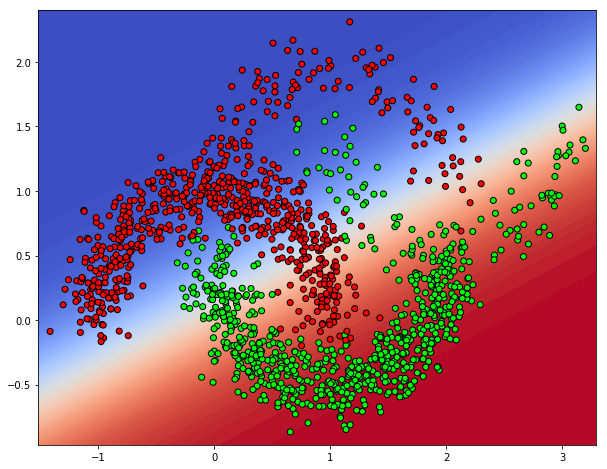

In [36]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = est.predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

## BENCHMARK LGBMClassifier

In [37]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [38]:
param_name = "reg_alpha"
param_range = np.logspace(-3, 3, 7)
param_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [39]:
%%time

train_scores, test_scores = validation_curve(
    LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    ),
    xtrain, np.argmax(ytrain, axis=1),
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] reg_alpha=0.001 .................................................
[CV] .................................. reg_alpha=0.001, total=   0.0s
[CV] reg_alpha=0.01 ..................................................
[CV] ................................... reg_alpha=0.01, total=   0.0s
[CV] reg_alpha=0.1 ...................................................
[CV] .................................... reg_alpha=0.1, total=   0.0s
[CV] reg_alpha=1.0 ...................................................
[CV] .................................... reg_alpha=1.0, total=   0.0s
[CV] reg_alpha=10.0 ..................................................
[CV] ................................... reg_alpha=10.0, total=   0.0s
[CV] reg_alpha=100.0 .................................................
[CV] .................................. reg_alpha=100.0, total=   0.0s
[CV] reg_alpha=1000.0 ................................................
[CV] ................................. reg_alpha=1000.0, total=   0.0s
[CV] r

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.7s finished


In [40]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[1.00000000e-03, 9.64406906e-01, 9.45967526e-01],
       [1.00000000e-02, 9.64406906e-01, 9.45967526e-01],
       [1.00000000e-01, 9.64065454e-01, 9.45333450e-01],
       [1.00000000e+00, 9.62358421e-01, 9.42168974e-01],
       [1.00000000e+01, 9.20268645e-01, 9.14212922e-01],
       [1.00000000e+02, 8.35166671e-01, 8.29121568e-01],
       [1.00000000e+03, 3.24324324e-01, 3.24324324e-01]])

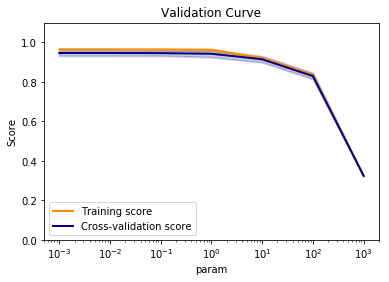

In [41]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [42]:
'''test data'''
est = LGBMClassifier(
        min_child_samples=20,
        reg_alpha=0.1
    )
est.fit(xtrain, np.argmax(ytrain, axis=1))

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=20,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0.1, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [43]:
pred = est.predict(xtrain)

In [44]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9726324998631626
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       720
           1       0.98      0.97      0.97       780

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[703  17]
 [ 24 756]]


In [45]:
pred_test = est.predict(xtest)

In [46]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9672756075049721
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       780
           1       0.97      0.96      0.97       720

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[757  23]
 [ 26 694]]


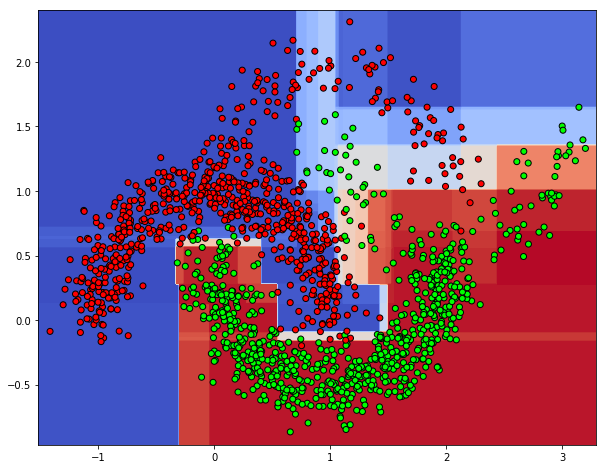

In [47]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = est.predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

## validation_curve + RBFClassifier
* looking for valid num_lm

In [48]:
cv_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.35, random_state=0)
cv_splitter.get_n_splits(xtrain, ytrain)

3

In [49]:
param_name = "num_lm"
param_range = [2, 5, 10, 20, 50, 100, 150, 200, 250, 300]
param_range

[2, 5, 10, 20, 50, 100, 150, 200, 250, 300]

In [50]:
%%time

def f1_scorer_2(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(np.argmax(y, axis=1), pred, average='macro')
    return s

train_scores, test_scores = validation_curve(
    RBFClassifier(
        num_lm=2,
        lm_select_from_x=True,
        random_state=None,
        lr=0.02, gamma='scale',
        epochs=500, batch_size=32, verbose=0
    ),
    xtrain, ytrain,
    param_name=param_name, param_range=param_range,
    cv=cv_splitter, n_jobs=1, verbose=2, scoring=f1_scorer_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] num_lm=2 ........................................................
[CV] ......................................... num_lm=2, total=  11.7s
[CV] num_lm=5 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ......................................... num_lm=5, total=  17.5s
[CV] num_lm=10 .......................................................
[CV] ........................................ num_lm=10, total=  15.9s
[CV] num_lm=20 .......................................................
[CV] ........................................ num_lm=20, total=  21.3s
[CV] num_lm=50 .......................................................
[CV] ........................................ num_lm=50, total=  29.9s
[CV] num_lm=100 ......................................................
[CV] ....................................... num_lm=100, total=  19.6s
[CV] num_lm=150 ......................................................
[CV] ....................................... num_lm=150, total=  25.0s
[CV] num_lm=200 ......................................................
[CV] ....................................... num_lm=200, total=  31.0s
[CV] num_lm=250 ......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.8min finished


In [51]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
np.c_[param_range, train_scores_mean, test_scores_mean]

array([[  2.        ,   0.73577915,   0.7267571 ],
       [  5.        ,   0.86140133,   0.8683623 ],
       [ 10.        ,   0.8614224 ,   0.86011368],
       [ 20.        ,   0.97123755,   0.95865542],
       [ 50.        ,   0.98698871,   0.9866426 ],
       [100.        ,   0.98801528,   0.98664712],
       [150.        ,   0.99109589,   0.98982338],
       [200.        ,   0.99109611,   0.98918781],
       [250.        ,   0.992808  ,   0.98918826],
       [300.        ,   0.992808  ,   0.98918826]])

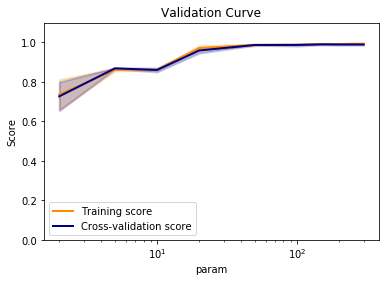

In [52]:
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

In [53]:
'''test data'''
est = RBFClassifier(
    num_lm=200,
    lm_select_from_x=True,
    random_state=None,
    lr=0.02, gamma='scale',
    epochs=500, batch_size=32, verbose=0
)
hst = est.fit(xtrain, ytrain)

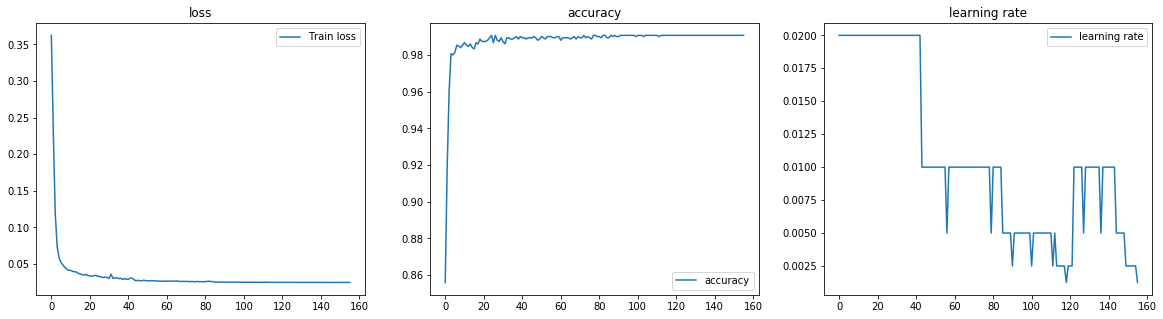

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [55]:
pred = est.predict(xtrain)

In [56]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9906506938965949
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       720
           1       0.99      0.99      0.99       780

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

[[712   8]
 [  6 774]]


In [57]:
pred_test = est.predict(xtest)

In [58]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9873150162167503
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       780
           1       0.98      0.99      0.99       720

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

[[769  11]
 [  8 712]]


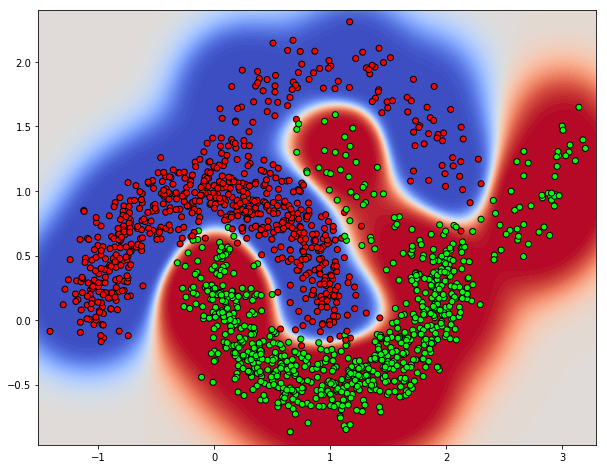

In [59]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = est.predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

## AdaBoostClassifier

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
clf = AdaBoostClassifier() # default classofier

In [62]:
clf.fit(xtrain, np.argmax(ytrain, axis=1))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [63]:
pred = clf.predict(xtrain)

In [64]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9452725250278087
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       720
           1       0.95      0.94      0.95       780

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500

[[684  36]
 [ 46 734]]


In [65]:
pred_test = clf.predict(xtest)

In [66]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9178896071384861
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       780
           1       0.91      0.92      0.91       720

   micro avg       0.92      0.92      0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500

[[716  64]
 [ 59 661]]


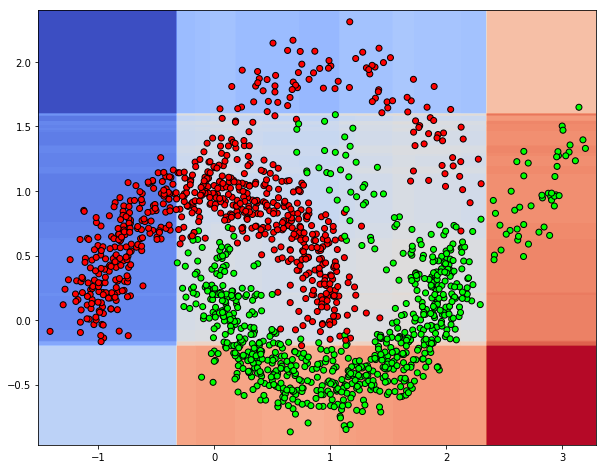

In [67]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

## AdaBoostClassifier + RBFClassifier

In [68]:
'''
バイアスの高い
num_lm=5
で実施
'''
clf = AdaBoostClassifier(
    RBFClassifier(
        num_lm=5,
        lm_select_from_x=True,
        random_state=None,
        lr=0.02, gamma='scale',
        epochs=500, batch_size=32, verbose=0,
        session_clear=False,
        make_model_gkernel=make_model_gkernel3
    ),
    n_estimators=50
)
# clf = AdaBoostClassifier(
#     LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', max_iter=10000, C=1000)
# )

In [69]:
%%time
clf.fit(xtrain, np.argmax(ytrain, axis=1))

CPU times: user 12min 39s, sys: 18 s, total: 12min 58s
Wall time: 18min


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<gkernel.sklearn.RBFClassifier object at 0x7fe828451a20>,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [70]:
[ee.current_gamma() for ee in clf.estimators_]

[2.165349,
 2.1533732,
 0.11251778,
 2.1088657,
 2.3643043,
 2.0816464,
 2.1472142,
 2.3745983,
 3.5431426,
 2.1880925,
 0.10546426,
 2.3973396,
 0.09987074,
 3.5912197,
 0.115042634,
 2.1679163,
 2.1696632,
 2.1790535,
 2.3492453,
 2.0801356,
 2.3596692,
 2.1642387,
 2.4100797,
 3.5383227,
 2.3332891,
 2.1677928,
 1.6895368,
 2.3457587,
 2.1886435,
 2.3441083,
 3.5320046,
 2.1531596,
 2.37125,
 2.178552,
 2.203094,
 2.1057842,
 0.1004478,
 2.1808116,
 2.151076,
 2.1612508,
 2.163574,
 2.170545,
 2.9067128,
 2.1892269,
 2.1588364,
 2.333512,
 2.1778653,
 2.4408882,
 2.3785026,
 1.8715761]

In [71]:
pred = clf.predict(xtrain)

In [72]:
print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))
print(classification_report(np.argmax(ytrain, axis=1), pred))
print(confusion_matrix(np.argmax(ytrain, axis=1), pred))

F1_SCORE : 0.9599794383247571
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       720
           1       0.98      0.94      0.96       780

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500

[[703  17]
 [ 43 737]]


In [73]:
pred_test = clf.predict(xtest)

In [74]:
print('F1_SCORE :', f1_score(np.argmax(yans, axis=1), pred_test, average='macro'))
print(classification_report(np.argmax(yans, axis=1), pred_test))
print(confusion_matrix(np.argmax(yans, axis=1), pred_test))

F1_SCORE : 0.9592023274737769
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       780
           1       0.97      0.94      0.96       720

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500

[[762  18]
 [ 43 677]]


In [75]:
clf.estimators_, clf.estimator_weights_

([<gkernel.sklearn.RBFClassifier at 0x7fe83c424550>,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [76]:
for pred in clf.staged_predict(xtrain):
    print('F1_SCORE :', f1_score(np.argmax(ytrain, axis=1), pred, average='macro'))

F1_SCORE : 0.9284475890849807
F1_SCORE : 0.9479907539118066
F1_SCORE : 0.9439745021734336
F1_SCORE : 0.9573139064178542
F1_SCORE : 0.9579820536682557
F1_SCORE : 0.959983993597439
F1_SCORE : 0.9606476201148022
F1_SCORE : 0.9599817872667382
F1_SCORE : 0.9613157276911803
F1_SCORE : 0.9613157276911803
F1_SCORE : 0.959983993597439
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9573139064178542
F1_SCORE : 0.9593159567264062
F1_SCORE : 0.9573139064178542
F1_SCORE : 0.9579820536682557
F1_SCORE : 0.9579820536682557
F1_SCORE : 0.9579820536682557
F1_SCORE : 0.9579820536682557
F1_SCORE : 0.9593159567264062
F1_SCORE : 0.9593159567264062
F1_SCORE : 0.9599817872667382
F1_SCORE : 0.9599817872667382
F1_SCORE : 0.9606476201148022
F1_SCORE : 0.9606476201148022
F1_SCORE : 0.9606476201148022
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9599794383247571
F1_SCORE : 0.9606476201148022
F1_SCORE : 0.9599794383247571
F1_SCORE : 0

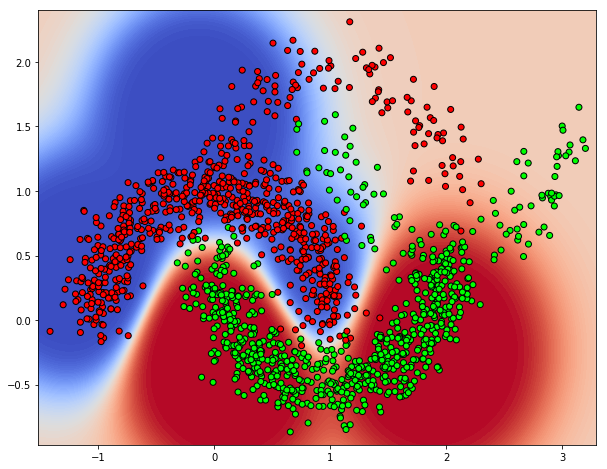

In [77]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = clf.estimators_[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])
y_pred

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

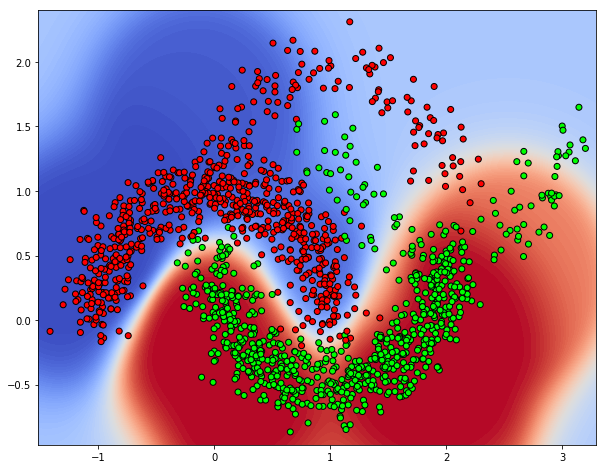

In [78]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(2)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

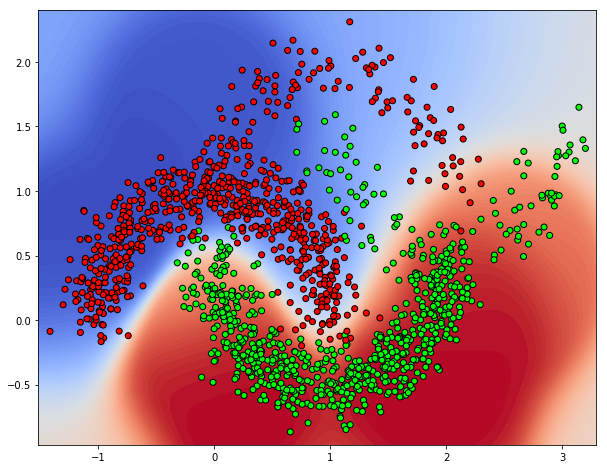

In [79]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(3)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

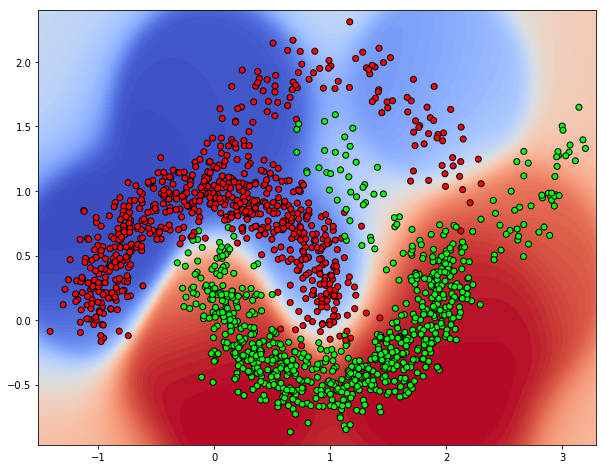

In [80]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(4)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

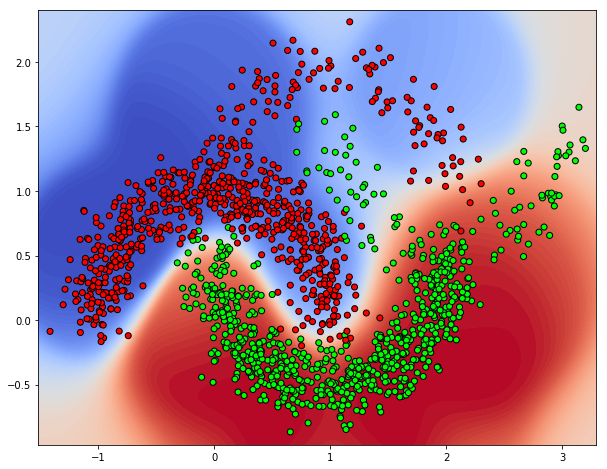

In [81]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(5)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

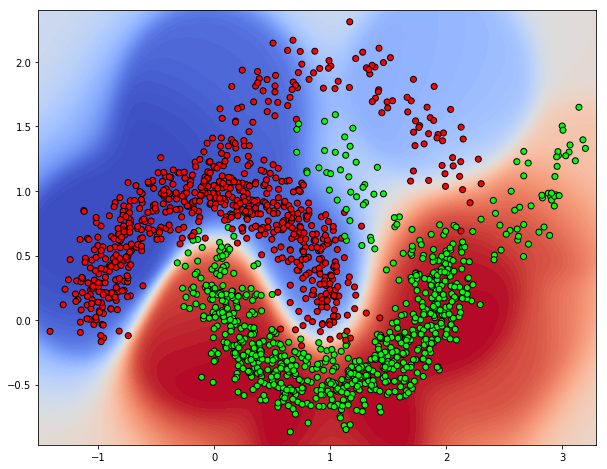

In [82]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(10)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

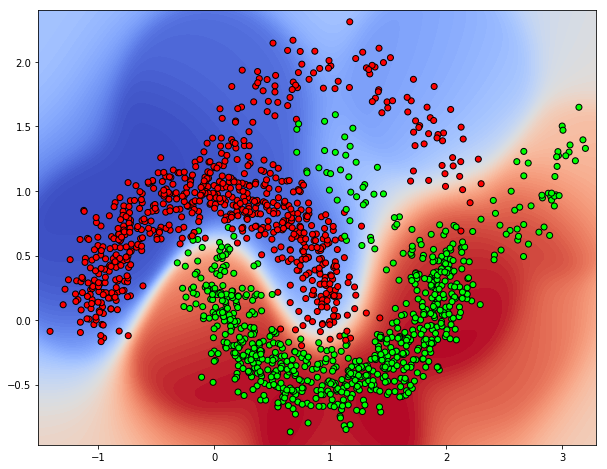

In [83]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(15)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')

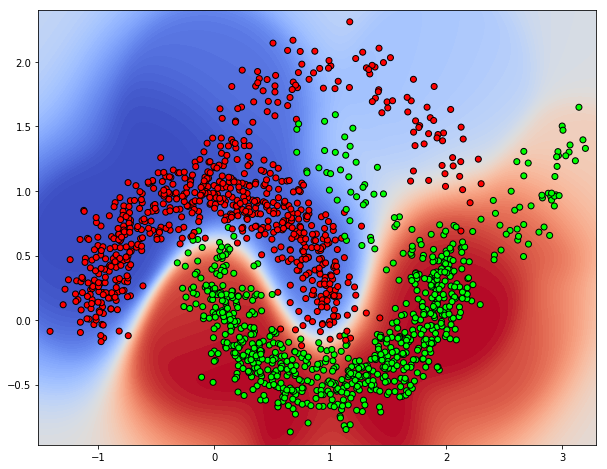

In [84]:
from matplotlib.colors import ListedColormap

h = .01
x_min, x_max = xtrain[:, 0].min() - .1, xtrain[:, 0].max() + .1
y_min, y_max = xtrain[:, 1].min() - .1, xtrain[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
y_pred = np.stack([clf.estimators_[ii].predict_proba(np.c_[xx.ravel(), yy.ravel()]) for ii in range(50)]).mean(axis=0)
#y_pred.mean(axis=0).shape

cm = plt.cm.coolwarm
cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
y_pred = y_pred[:,1].reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=np.argmax(ytrain, axis=1), cmap=cm_bright, edgecolors='k')